# Bounding box detection - Racoon data


## Data files
- images_racoon.rar: contain images of racoons
- train_labels.cv: contains coordinates for bounding box for every image

### Import the necessary libraries

In [9]:
# IMPORT LIBRARIES AND PACKAGES
import tensorflow as tf
import csv
import numpy as np
from PIL import Image
import pandas as pd

from keras import Model
from keras.applications.mobilenet import MobileNet, preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from keras.utils import Sequence
from keras.backend import epsilon

In [89]:
tf.__version__

'2.3.0'

### Change directory

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
os.chdir('/content/drive/My Drive/GL-AIML/ACV Lab Questions and Data Set/')

In [67]:
!pwd

/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set


### Load the training data from train.csv file

In [14]:
DATASET_FOLDER = '/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set'
TRAIN_CSV = "train_labels.csv"
df = pd.read_csv(TRAIN_CSV)
df.head(10)

,filename,width,height,class,xmin,ymin,xmax,ymax
0,raccoon-17.jpg,259,194,raccoon,95,60,167,118
1,raccoon-11.jpg,660,432,raccoon,3,1,461,431
2,raccoon-63.jpg,600,400,raccoon,74,107,280,290
3,raccoon-63.jpg,600,400,raccoon,227,93,403,298
4,raccoon-60.jpg,273,185,raccoon,58,33,197,127
5,raccoon-69.jpg,205,246,raccoon,12,11,188,240
6,raccoon-180.jpg,600,400,raccoon,119,21,368,399
7,raccoon-200.jpg,261,193,raccoon,107,10,249,166
8,raccoon-141.jpg,249,202,raccoon,1,1,154,176
9,raccoon-19.jpg,259,194,raccoon,87,8,182,89


In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 173 entries, 0 to 172
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   class     173 non-null    object
 1   filename  173 non-null    object
 2   width     173 non-null    int64 
 3   height    173 non-null    int64 
 4   xmin      173 non-null    int64 
 5   ymin      173 non-null    int64 
 6   xmax      173 non-null    int64 
 7   ymax      173 non-null    int64 
dtypes: int64(6), object(2)
memory usage: 10.9+ KB


In [38]:
# moving the class col to first
col = df.pop("class")
df.insert(0, col.name, col)
df.head()

,class,filename,width,height,xmin,ymin,xmax,ymax
0,raccoon,raccoon-17.jpg,259,194,95,60,167,118
1,raccoon,raccoon-11.jpg,660,432,3,1,461,431
2,raccoon,raccoon-63.jpg,600,400,74,107,280,290
3,raccoon,raccoon-63.jpg,600,400,227,93,403,298
4,raccoon,raccoon-60.jpg,273,185,58,33,197,127


### Print the shape of the train dataset

In [15]:
df.shape

(173, 8)

### Declare a variable IMAGE_SIZE = 128 as we will be using MobileNet which will be taking Input shape as 128 * 128 

In [16]:
IMAGE_SIZE = 128

### With the help of csv.reader write a for loop which can load the train.csv file and store the path, width, height, x0,y0,x1,y1 in induvidual variables. <br>
1. Create a list variable known as 'path' which has all the path for all the training images
2. Create an array 'coords' which has the resized coordinates of the bounding box for the training images

<u>Note:</u> All the training images should be downsampled to 128 * 128 as it is the input shape of MobileNet (which we will be using for Object detection). Hence the corresponding coordinates of the bounding boxes should be changed to match the image dimension of 128 * 128 

In [81]:
import csv
with open(TRAIN_CSV, 'r') as csvfile:
    paths = []
    coords = np.zeros((sum(1 for line in csvfile)-1, 4))
    reader = csv.reader(csvfile, delimiter=',')
    csvfile.seek(0)
    next(reader,None)
    for col, row in enumerate(reader):
        print('row ', row)         
        for i, r in enumerate(row[1:7]):
            row[i+1] = r
        path, width, height,_ , x0, y0, x1, y1 = row  
        x0 = int(x0)
        y0 = int(y0)
        x1 = int(x1)        
        y1 = int(y1)
        height = int(height)
        width = int(width)
        path = '/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set/images/' + path
        print(path, width, height, x0, y0, x1, y1)
        # path = "./" + path.split('/')[-2] + "/" + path.split('/')[-1]
        coords[col, 0] = x0 * IMAGE_SIZE / width 
        coords[col, 1] = y0 * IMAGE_SIZE / height
        coords[col, 2] = (x1 - x0) * IMAGE_SIZE / width
        coords[col, 3] = (y1 - y0) * IMAGE_SIZE / height        
        paths.append(path)

row  ['raccoon-17.jpg', '259', '194', 'raccoon', '95', '60', '167', '118']
/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set/images/raccoon-17.jpg 259 194 95 60 167 118
row  ['raccoon-11.jpg', '660', '432', 'raccoon', '3', '1', '461', '431']
/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set/images/raccoon-11.jpg 660 432 3 1 461 431
row  ['raccoon-63.jpg', '600', '400', 'raccoon', '74', '107', '280', '290']
/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set/images/raccoon-63.jpg 600 400 74 107 280 290
row  ['raccoon-63.jpg', '600', '400', 'raccoon', '227', '93', '403', '298']
/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set/images/raccoon-63.jpg 600 400 227 93 403 298
row  ['raccoon-60.jpg', '273', '185', 'raccoon', '58', '33', '197', '127']
/

### Write a for loop which can load all the training images into a variable 'batch_images' using the paths from the 'paths' variable
<u>Note:</u> Convert the image to RGB scale as the MobileNet accepts 3 channels as inputs   

In [83]:
batch_images = np.zeros((len(paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
for i, f in enumerate(paths):
    img = Image.open(f) # Read image
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE)) # Resize image
    img = img.convert('RGB')
    batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))          

In [82]:
# ensure x and y

print(coords.shape)
print(batch_images.shape)

(173, 4)
(173, 128, 128, 3)


### Import MobileNet and load MobileNet into a variable named 'model' which takes input shape of 128 * 128 * 3. Freeze all the layers. Add convolution and reshape layers at the end to ensure the output is 4 coordinates

In [84]:
ALPHA = 1.0
model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA) # Load pre-trained mobilenet
# Do not include classification (top) layer

# to freeze layers, except the new top layer, of course, which will be added below
for layer in model.layers:
    layer.trainable = False

# Add new top layer which is a conv layer of the same size as the previous layer so that only 4 coords of BBox can be output
x = model.layers[-1].output
x = Conv2D(4, kernel_size=4, name="coords")(x)
x = Reshape((4,))(x) # These are the 4 predicted coordinates of one BBox

model = Model(inputs=model.input, outputs=x)

In [85]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)       

### Define a custom loss function IoU which calculates Intersection Over Union

In [90]:
def loss(gt,pred):
    intersections = 0
    unions = 0
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height
    
    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

#     Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + epsilon()), 4)
    iou = iou.astype(np.float32)
    return iou

def IoU(y_true, y_pred):
    iou = tf.py_function(loss, [y_true, y_pred], tf.float32)
    return iou

### Write model.compile function & model.fit function with: <br>
1. Optimizer = Adam, Loss = 'mse' and metrics = IoU
2. Epochs = 30, batch_size = 32, verbose = 1

In [91]:
model.compile(optimizer='Adam', loss='mse', metrics=[IoU]) # Regression loss is MSE

model.fit(batch_images,coords,epochs=30,batch_size = 32,verbose=1)

Epoch 1/30
6/6 [==============================] - 0s 76ms/step - loss: 2711.2666 - IoU: 0.1230
Epoch 2/30
6/6 [==============================] - 0s 47ms/step - loss: 606.4083 - IoU: 0.4625
Epoch 3/30
6/6 [==============================] - 0s 46ms/step - loss: 672.9525 - IoU: 0.5292
Epoch 4/30
6/6 [==============================] - 0s 45ms/step - loss: 540.6199 - IoU: 0.5616
Epoch 5/30
6/6 [==============================] - 0s 47ms/step - loss: 308.4753 - IoU: 0.6060
Epoch 6/30
6/6 [==============================] - 0s 45ms/step - loss: 249.1873 - IoU: 0.5771
Epoch 7/30
6/6 [==============================] - 0s 48ms/step - loss: 205.1029 - IoU: 0.6481
Epoch 8/30
6/6 [==============================] - 0s 51ms/step - loss: 163.4785 - IoU: 0.6918
Epoch 9/30
6/6 [==============================] - 0s 52ms/step - loss: 132.9822 - IoU: 0.7302
Epoch 10/30
6/6 [==============================] - 0s 51ms/step - loss: 116.5832 - IoU: 0.7523
Epoch 11/30
6/6 [==============================] - 0s 51ms

### Pick a test image from the given data

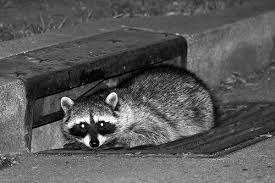

In [98]:
import cv2
from google.colab.patches import cv2_imshow
filename = '/content/drive/.shortcut-targets-by-id/1_HSwXf7FzezDRMI0NTZDqAvo3gfDzOH6/GL-AIML/ACV Lab Questions and Data Set/images/raccoon-152.jpg'
img = cv2.imread(filename) # Original image for display
cv2_imshow(img) 

### Resize the image to 128 * 128 and preprocess the image for the MobileNet model

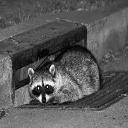

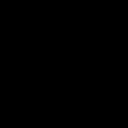

In [106]:
image_width, image_height, _ = img.shape
image = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
# resized
cv2_imshow(image) 
# pre-process
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
cv2_imshow(feat_scaled) 

### Predict the coordinates of the bounding box for the given test image

In [107]:
region = model.predict(x=np.array([feat_scaled]))[0] # Predict the BBox

### Plot the test image using .imshow and draw a boundary box around the image with the coordinates obtained from the model

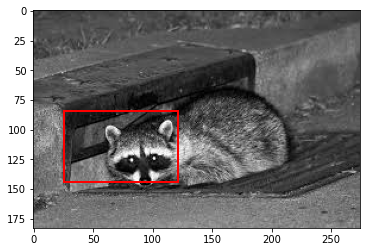

In [108]:
x0 = int(region[0] * image_width / IMAGE_SIZE) # Scale the BBox
y0 = int(region[1] * image_height / IMAGE_SIZE)

x1 = int((region[2]) * image_width / IMAGE_SIZE)
y1 = int((region[3]) * image_height / IMAGE_SIZE)


import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np


# Create figure and axes
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(img)

# Create a Rectangle patch
rect = patches.Rectangle((x0, y0), (x1 - x0) , (y1 - y0) , linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()